In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta
import yfinance as yf
import pandas_ta
from ta.momentum import StochasticOscillator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression

C:\Users\daksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas_ta\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
#pip install xgboost

In [4]:
#pip install openpyxl


In [5]:
#pip install pandas-ta

In [6]:
df = yf.download("EURUSD=X", interval="1d", period="10y")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
def remove_outliers_iqr(df, column, multiplier=2.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    df = df.copy()
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = np.nan
    df[column] = df[column].fillna(method='ffill')
    return df

In [8]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,,
2015-07-20,1.083025,1.087200,1.082157,1.083295,0
2015-07-21,1.083541,1.094070,1.081270,1.083482,0
2015-07-22,1.093996,1.097000,1.088140,1.093900,0
2015-07-23,1.092705,1.102000,1.092395,1.092705,0
2015-07-24,1.098901,1.099602,1.092790,1.098841,0


In [9]:
df = df.drop('Volume', axis=1)  # axis=1 means column
df

Price,Close,High,Low,Open
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,
2015-07-20,1.083025,1.087200,1.082157,1.083295
2015-07-21,1.083541,1.094070,1.081270,1.083482
2015-07-22,1.093996,1.097000,1.088140,1.093900
2015-07-23,1.092705,1.102000,1.092395,1.092705
2015-07-24,1.098901,1.099602,1.092790,1.098841
...,...,...,...,...
2025-07-14,1.168211,1.169864,1.165664,1.168211
2025-07-15,1.166630,1.169208,1.160214,1.166630


In [10]:
df = df.reset_index()


In [11]:
df.columns = df.columns.get_level_values(0)

In [12]:
df

Price,Date,Close,High,Low,Open
0,2015-07-20,1.083025,1.087200,1.082157,1.083295
1,2015-07-21,1.083541,1.094070,1.081270,1.083482
2,2015-07-22,1.093996,1.097000,1.088140,1.093900
3,2015-07-23,1.092705,1.102000,1.092395,1.092705
4,2015-07-24,1.098901,1.099602,1.092790,1.098841
...,...,...,...,...,...
2599,2025-07-14,1.168211,1.169864,1.165664,1.168211
2600,2025-07-15,1.166630,1.169208,1.160214,1.166630
2601,2025-07-16,1.160739,1.171674,1.156404,1.160739
2602,2025-07-17,1.163575,1.163575,1.156939,1.163575


In [13]:
# df = pd.read_excel(r"C:\Users\daksh\Downloads\company_data.xlsx")
# print(df.head())

In [14]:
df.columns = df.columns.str.lower()
df


Price,date,close,high,low,open
0,2015-07-20,1.083025,1.087200,1.082157,1.083295
1,2015-07-21,1.083541,1.094070,1.081270,1.083482
2,2015-07-22,1.093996,1.097000,1.088140,1.093900
3,2015-07-23,1.092705,1.102000,1.092395,1.092705
4,2015-07-24,1.098901,1.099602,1.092790,1.098841
...,...,...,...,...,...
2599,2025-07-14,1.168211,1.169864,1.165664,1.168211
2600,2025-07-15,1.166630,1.169208,1.160214,1.166630
2601,2025-07-16,1.160739,1.171674,1.156404,1.160739
2602,2025-07-17,1.163575,1.163575,1.156939,1.163575


In [15]:
for col in ['open', 'high', 'low', 'close']:
    df = remove_outliers_iqr(df, col)

C:\Users\daksh\AppData\Local\Temp\ipykernel_18964\3413062863.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')
C:\Users\daksh\AppData\Local\Temp\ipykernel_18964\3413062863.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')
C:\Users\daksh\AppData\Local\Temp\ipykernel_18964\3413062863.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')
C:\Users\daksh\AppData\Local\Temp\ipykernel_18964\3413062863.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')


In [16]:
print(df.describe())

Price                           date        close         high          low  \
count                           2604  2604.000000  2604.000000  2604.000000   
mean   2020-07-17 12:03:52.258064384     1.118275     1.121752     1.114765   
min              2015-07-20 00:00:00     0.959619     0.967006     0.954016   
25%              2018-01-17 18:00:00     1.083201     1.086472     1.080264   
50%              2020-07-18 12:00:00     1.114554     1.117781     1.111062   
75%              2023-01-16 06:00:00     1.157026     1.160955     1.153466   
max              2025-07-18 00:00:00     1.251001     1.255808     1.245051   
std                              NaN     0.053149     0.052949     0.053309   

Price         open  
count  2604.000000  
mean      1.118254  
min       0.959619  
25%       1.083236  
50%       1.114566  
75%       1.156989  
max       1.251267  
std       0.053139  


In [17]:
print(df['close'].dtype)

float64


In [18]:
df.columns



Index(['date', 'close', 'high', 'low', 'open'], dtype='object', name='Price')

In [19]:
def add_indicators(df):
    df = df.copy()
    
    # Simple Moving Averages
    for window in [14, 50, 100, 200]:
        df[f'SMA_{window}'] = ta.trend.SMAIndicator(close=df['close'], window=window).sma_indicator()
    
    # RSI 14
    df['RSI_14'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
    
    # MACD (12,26,9)
    macd = ta.trend.MACD(close=df['close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    
    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()

    return df

In [20]:
# Add swing high and trend line features
df.loc[:, 'swing_high'] = (df['high'] > df['high'].rolling(window=5).max().shift(1))
high_points = df[df['swing_high']][['date', 'high']]
print(f"Number of swing highs: {len(high_points)}")
if len(high_points) > 0:
    high_points['index'] = high_points.index
    X_trend = high_points['index'].values.reshape(-1, 1)
    y_trend = high_points['high'].values
    trend_model = LinearRegression().fit(X_trend, y_trend)
    df.loc[:, 'trend_line'] = trend_model.predict(df.index.values.reshape(-1, 1))
    df.loc[:, 'distance_to_trend'] = df['close'] - df['trend_line']
    df.loc[:, 'breakout'] = (df['close'] > df['trend_line']).astype(int)
else:
    X_trend = df.index.values.reshape(-1, 1)
    y_trend = df['close'].values
    trend_model = LinearRegression().fit(X_trend, y_trend)
    df.loc[:, 'trend_line'] = trend_model.predict(X_trend)
    df.loc[:, 'distance_to_trend'] = df['close'] - df['trend_line']
    df.loc[:, 'breakout'] = (df['close'] > df['trend_line']).astype(int)
    print("No swing highs detected; using linear trend on all closes")
df = df.dropna()

Number of swing highs: 621


In [21]:
df = add_indicators(df)

In [22]:
df['return_1d'] = df['close'].pct_change()
df['return_5d'] = df['close'].pct_change(5)
df['volatility_5d'] = df['close'].rolling(5).std()
df['sma_ratio'] = df['SMA_14'] / df['SMA_50']


In [23]:
df

Price,date,close,high,low,open,swing_high,trend_line,distance_to_trend,breakout,SMA_14,...,SMA_200,RSI_14,MACD,MACD_Signal,Stoch_K,Stoch_D,return_1d,return_5d,volatility_5d,sma_ratio
0,2015-07-20,1.083025,1.087200,1.082157,1.083295,False,1.158318,-0.075293,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-07-21,1.083541,1.094070,1.081270,1.083482,False,1.158294,-0.074753,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000477,NaN,NaN,NaN
2,2015-07-22,1.093996,1.097000,1.088140,1.093900,False,1.158270,-0.064274,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.009649,NaN,NaN,NaN
3,2015-07-23,1.092705,1.102000,1.092395,1.092705,False,1.158247,-0.065542,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.001180,NaN,NaN,NaN
4,2015-07-24,1.098901,1.099602,1.092790,1.098841,False,1.158223,-0.059322,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.005670,NaN,0.006927,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,2025-07-14,1.168211,1.169864,1.165664,1.168211,False,1.096970,0.071241,1,1.173129,...,1.088271,56.709997,0.007682,0.009219,38.084135,53.362439,-0.001764,-0.008376,0.002263,1.022828
2600,2025-07-15,1.166630,1.169208,1.160214,1.166630,False,1.096946,0.069683,1,1.173515,...,1.088579,54.693339,0.006787,0.008733,28.124853,38.218694,-0.001353,-0.005985,0.002752,1.022535
2601,2025-07-16,1.160739,1.171674,1.156404,1.160739,False,1.096923,0.063816,1,1.172969,...,1.088865,47.863158,0.005538,0.008094,16.285682,27.498224,-0.005049,-0.009994,0.004631,1.021589
2602,2025-07-17,1.163575,1.163575,1.156939,1.163575,False,1.096899,0.066676,1,1.172566,...,1.089196,51.033886,0.004723,0.007420,26.939214,23.783250,0.002443,-0.008133,0.003777,1.020652


In [24]:
df['future_return'] = df['close'].pct_change(periods=3).shift(-3)
df['Target'] = (df['future_return'] > 0.001).astype(int)
df = df.dropna().reset_index(drop=True)


In [25]:
df

Price,date,close,high,low,open,swing_high,trend_line,distance_to_trend,breakout,SMA_14,...,MACD,MACD_Signal,Stoch_K,Stoch_D,return_1d,return_5d,volatility_5d,sma_ratio,future_return,Target
0,2016-04-22,1.129203,1.130902,1.124000,1.129305,False,1.153620,-0.024417,0,1.134755,...,0.003442,0.005153,24.574649,36.361767,-0.001152,0.001954,0.002676,1.014415,0.000621,0
1,2016-04-25,1.123406,1.127904,1.122700,1.123305,False,1.153597,-0.030191,0,1.133648,...,0.002500,0.004622,2.980232,19.280261,-0.005134,-0.005831,0.004493,1.013411,0.008451,1
2,2016-04-26,1.126900,1.133903,1.125796,1.126672,False,1.153573,-0.026673,0,1.132841,...,0.002012,0.004100,17.722952,15.092611,0.003110,-0.003539,0.004645,1.012518,0.007711,1
3,2016-04-27,1.129905,1.134000,1.129200,1.129803,False,1.153549,-0.023644,0,1.132084,...,0.001847,0.003650,30.402394,17.035193,0.002667,-0.005333,0.002901,1.011566,0.014512,1
4,2016-04-28,1.132901,1.136600,1.129905,1.132798,False,1.153526,-0.020625,0,1.131763,...,0.001935,0.003307,43.041095,30.388813,0.002651,0.002119,0.003547,1.010907,0.017299,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2397,2025-07-09,1.172457,1.172883,1.169085,1.172457,False,1.097041,0.075416,1,1.169533,...,0.009894,0.010000,71.793966,78.096037,-0.001020,-0.006859,0.003143,1.021780,-0.003621,0
2398,2025-07-10,1.173117,1.175088,1.166575,1.173117,False,1.097017,0.076100,1,1.171093,...,0.009328,0.009866,73.556088,73.600981,0.000563,-0.005854,0.002543,1.022417,-0.005530,0
2399,2025-07-11,1.170275,1.171372,1.166589,1.170275,False,1.096994,0.073281,1,1.172535,...,0.008552,0.009603,48.447094,64.599049,-0.002423,-0.005840,0.002856,1.022951,-0.008148,0
2400,2025-07-14,1.168211,1.169864,1.165664,1.168211,False,1.096970,0.071241,1,1.173129,...,0.007682,0.009219,38.084135,53.362439,-0.001764,-0.008376,0.002263,1.022828,-0.003968,0


In [26]:
features = ['Stoch_K', 'SMA_100', 'SMA_14', 'SMA_50', 'MACD', 'RSI_14', 'Stoch_D', 'MACD_Signal', 'SMA_200',
            'return_1d', 'return_5d', 'volatility_5d', 'sma_ratio']

In [27]:
X = df[features]
y = df["Target"]


In [28]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False, random_state=42)

In [30]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    reg_alpha=0.1,# L1 regularization (for sparsity)
    reg_lambda=1.0 )

In [31]:
#Hyperparameter Tuning with GridSearchCV and TimeSeriesSplit on training set
param_grid = {
    'n_estimators': [150,200],
    'max_depth': [3],
    'min_child_weight': [25,20,30],  # Regularization parameter for XGBoost
    'learning_rate': [0.05,0.1,],
    'gamma': [0.1,0.2,0.3],  # Minimum loss reduction for split
    'reg_alpha':[0,0.1,0.5],
    'reg_lambda':[1,5,10]
}
tscv = TimeSeriesSplit(n_splits=3)
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                        param_grid, cv=tscv,
                        scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("Best params:", xgb_grid.best_params_)
best_xgb_model = xgb_grid.best_estimator_

C:\Users\daksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [17:39:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1}


In [32]:
best_xgb_model.fit(X_train, y_train)  # Train the model


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=25, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [33]:
# Threshold tuning
probs = best_xgb_model.predict_proba(X_test)[:, 1]
best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.3, 0.65, 0.01):
    preds = (probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
print("Best Threshold:", best_thresh)
y_pred = (probs > best_thresh).astype(int)

Best Threshold: 0.33


In [34]:
print("Training Accuracy:", accuracy_score(y_train, best_xgb_model.predict(X_train)))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Training Accuracy: 0.7730348776678813
Testing Accuracy: 0.5239085239085239
F1 Score: 0.6449612403100775
              precision    recall  f1-score   support

           0       0.69      0.17      0.28       253
           1       0.50      0.91      0.64       228

    accuracy                           0.52       481
   macro avg       0.59      0.54      0.46       481
weighted avg       0.60      0.52      0.45       481

Confusion Matrix:
 [[ 44 209]
 [ 20 208]]


In [35]:
print("Train F1:", f1_score(y_train, best_xgb_model.predict(X_train)))
print("Test F1:", f1_score(y_test, best_xgb_model.predict(X_test)))

Train F1: 0.7029972752043597
Test F1: 0.4690831556503198


In [57]:
# Predict signals from test set
y_pred = best_xgb_model.predict(X_test)

test_df = df.iloc[-len(X_test):].copy()
test_df['Signal'] = y_pred
test_df['Date'] = test_df.index
test_df[['date', 'open', 'high', 'low', 'close', 'Signal']].to_csv("signals.csv", index=False)
print("✅ signals.csv exported successfully.")


✅ signals.csv exported successfully.


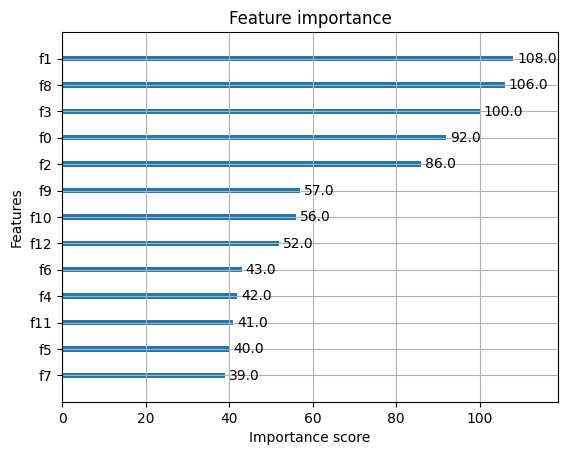

In [37]:
# Feature selection
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel

plot_importance(best_xgb_model)
selector = SelectFromModel(best_xgb_model, threshold='median', prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

In [38]:
# Backtesting
def backtest(df, signals, initial=10000, spread=0.0001):
    df = df.copy()
    df['Signal'] = signals
    df['Returns'] = df['close'].pct_change()
    df['Strategy'] = df['Returns'] * df['Signal'].shift(1)
    df['Strategy'] -= (df['Signal'] != df['Signal'].shift(1)).astype(int) * spread
    df['Cumulative Market'] = (1 + df['Returns']).cumprod() * initial
    df['Cumulative Strategy'] = (1 + df['Strategy']).cumprod() * initial
    return df
df_test = df.iloc[-len(X_test):].copy()
df_test= backtest(df_test,y_pred)
cumulative_returns = backtest(df_test, y_pred)

C:\Users\daksh\AppData\Local\Temp\ipykernel_18964\1945789504.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\daksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


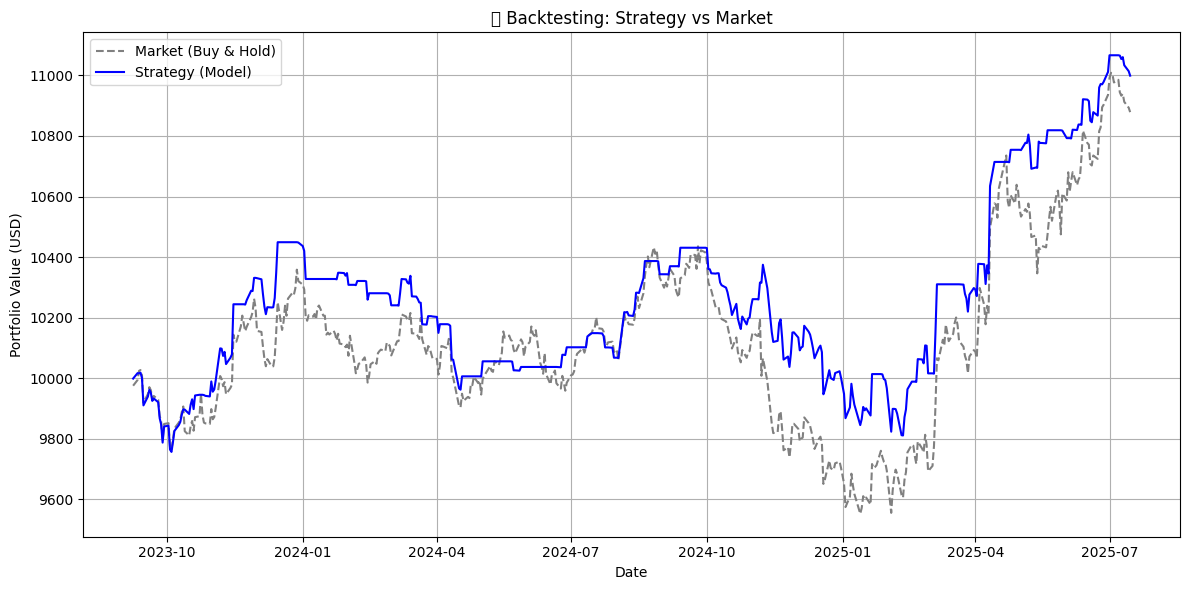

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_test['date'], df_test['Cumulative Market'], label='Market (Buy & Hold)', color='gray', linestyle='--')
plt.plot(df_test['date'], df_test['Cumulative Strategy'], label='Strategy (Model)', color='blue')

plt.title('📈 Backtesting: Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


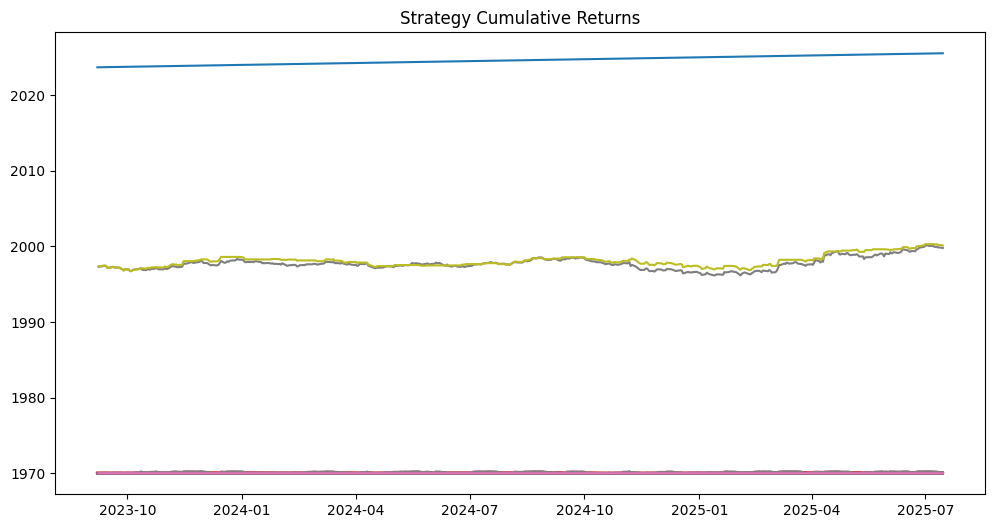

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df_test['date'], cumulative_returns)
plt.title('Strategy Cumulative Returns')
plt.show()

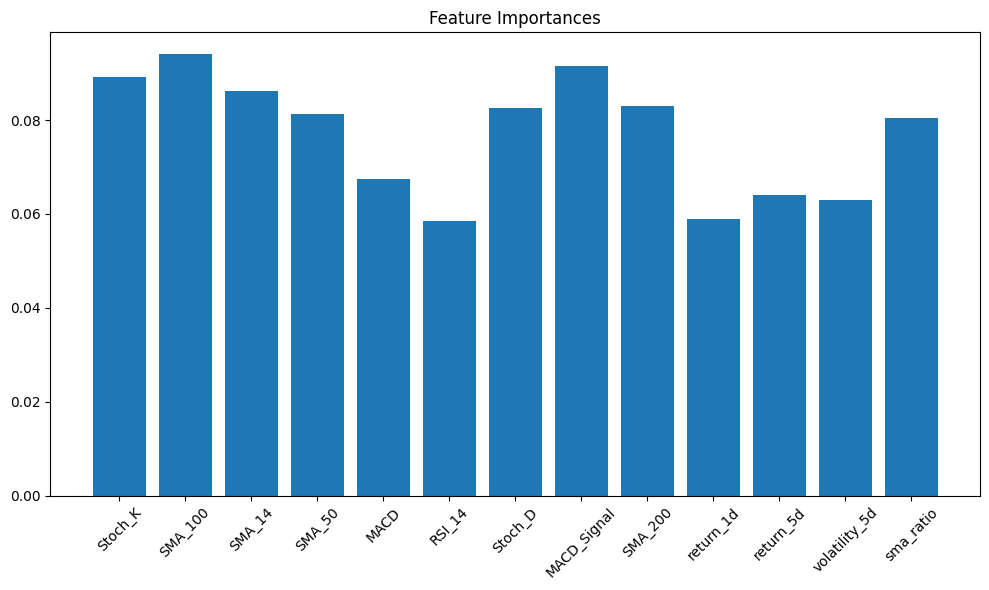

In [41]:
importances = best_xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(features, importances)
plt.xticks(rotation=45)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [42]:
# train_preds = best_xgb_model.predict(X_train)
# test_preds = best_xgb_model.predict(X_test)
# train_acc = accuracy_score(y_train, train_preds)
# test_acc = accuracy_score(y_test, test_preds)
# print(f"✅ Training Accuracy: {train_acc:.4f}")
# print(f"✅ Testing Accuracy: {test_acc:.4f}")

In [43]:
# # Step 1: Get feature importances from the trained model
# importances = best_xgb_model.feature_importances_

# # Step 2: Create a DataFrame
# feature_importance_df = pd.DataFrame({
#     'Feature': features,
#     'Importance': importances
# }).sort_values(by='Importance', ascending=False)

# # Step 3: Print nicely
# print("🔍 Feature Importances:")
# print(feature_importance_df.to_string(index=False))

# # Step 4: Remove features with very low importance (threshold can be adjusted)
# threshold = 0.01
# selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()

# print("\n✅ Selected Features (Importance > 0.01):", selected_features)

# # Step 5 (Optional): Update X to only use selected features
# X = df[selected_features]


In [44]:
# #Hyperparameter Tuning with GridSearchCV and TimeSeriesSplit
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_leaf': [1, 3, 5],
#     'min_samples_split': [2, 10, 20]
# }
# tscv = TimeSeriesSplit(n_splits=5)
# grid = GridSearchCV(RandomForestClassifier(random_state=42),
#                     param_grid, cv=tscv,
#                     scoring='accuracy', n_jobs=-1)
# grid.fit(X_scaled, y)
# print("Best params:", grid.best_params_)
# best_model = grid.best_estimator_

In [45]:
# # Split data into train and test for final evaluation (last split as test)
# tscv = TimeSeriesSplit(n_splits=5)
# for train_index, test_index in tscv.split(X_scaled):
#     if train_index[-1] < test_index[0]:  # Ensure last split is used for test
#         X_train, X_test = X_scaled[train_index], X_scaled[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#         break

In [46]:
# train_preds = best_model.predict(X_train)
# test_preds = best_model.predict(X_test)
# train_acc = accuracy_score(y_train, train_preds)
# test_acc = accuracy_score(y_test, test_preds)
# print(f"✅ Training Accuracy: {train_acc:.4f}")
# print(f"✅ Testing Accuracy: {test_acc:.4f}")

In [47]:
# # Detailed Metrics
# print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))
# print("Classification Report:\n", classification_report(y_test, test_preds))

In [48]:
# model = RandomForestClassifier(
#     n_estimators=200,
#     max_depth = 20,
#     min_samples_split = 10,
#     min_samples_leaf=5,
#     random_state=42)
# model.fit(X_train, y_train)


In [49]:
# model.fit(X_train, y_train)
# train_acc = model.score(X_train, y_train)
# test_preds = model.predict(X_test)
# test_acc = accuracy_score(y_test, test_preds)
# print(f"Initial Training Accuracy: {train_acc:.4f}")
# print(f"Initial Testing Accuracy: {test_acc:.4f}")

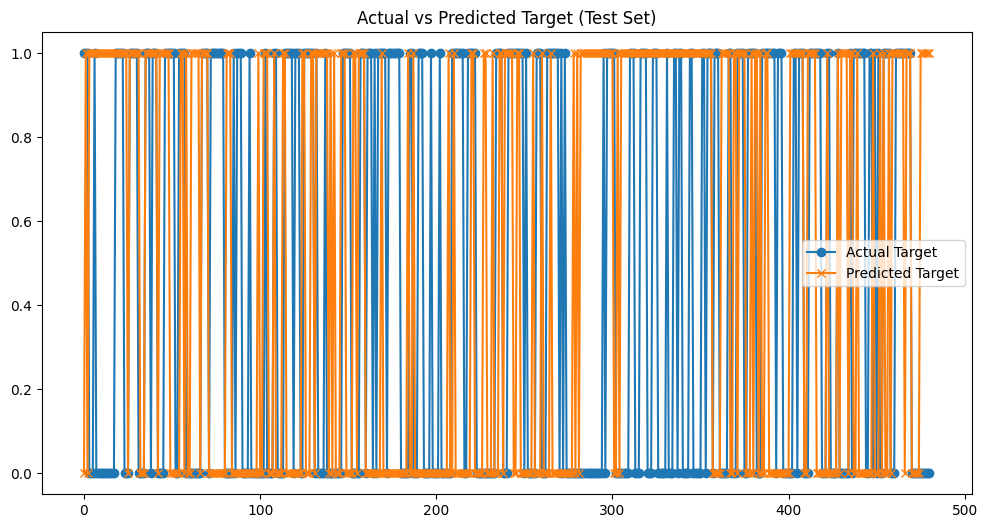

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Target', marker='o')
plt.plot(y_pred, label='Predicted Target', marker='x')
plt.title('Actual vs Predicted Target (Test Set)')
plt.legend()
plt.show()

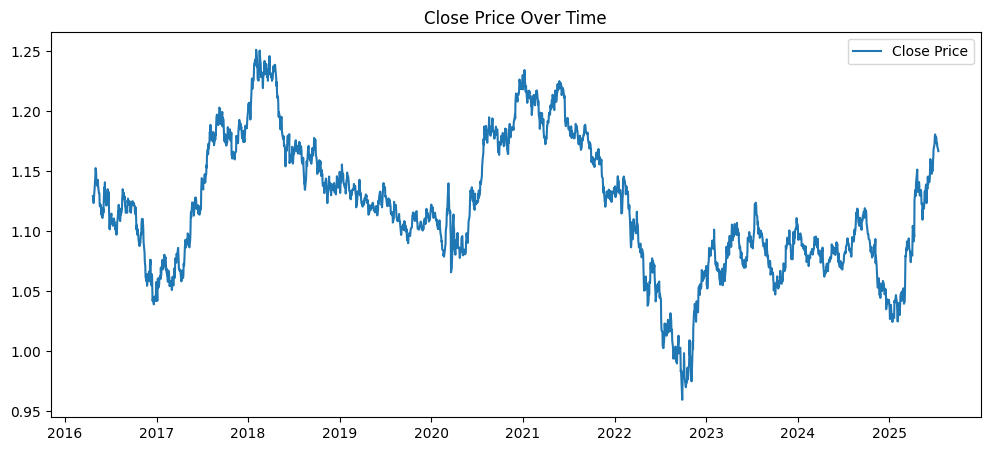

In [51]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['close'], label='Close Price')
plt.title('Close Price Over Time')
plt.legend()
plt.show()

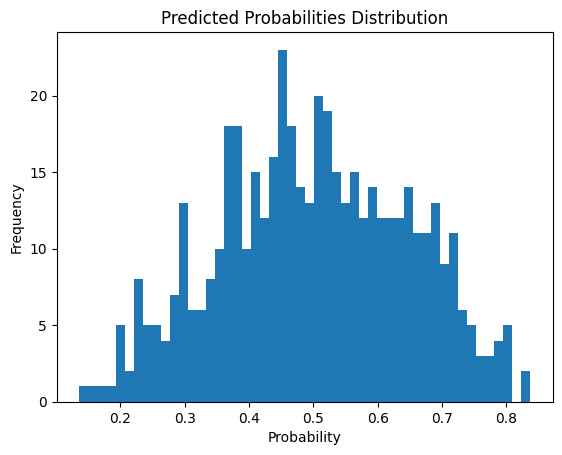

In [52]:
import matplotlib.pyplot as plt

plt.hist(probs, bins=50)
plt.title("Predicted Probabilities Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()


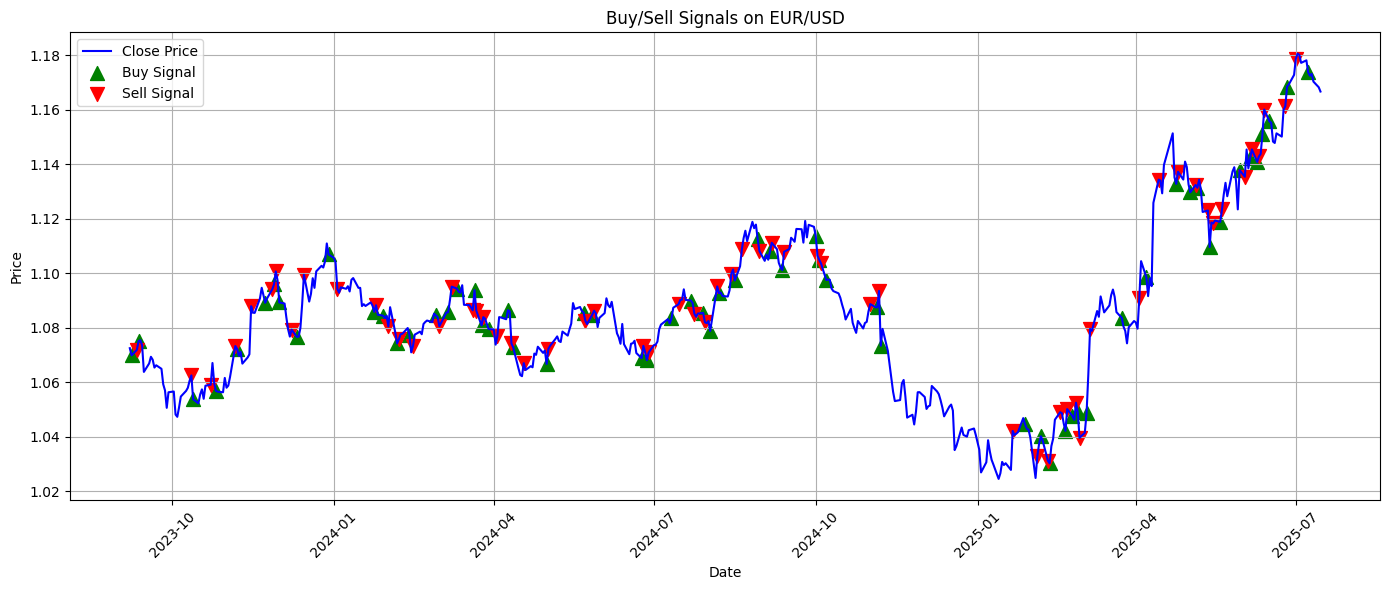

In [53]:
import matplotlib.dates as mdates

# Prepare the signal DataFrame
df_signals = df.iloc[-len(y_test):].copy().reset_index(drop=True)
df_signals['Signal'] = y_pred.flatten()
df_signals['Price'] = df_signals['close']

# Identify signals
buy_signals = df_signals[(df_signals['Signal'] == 1) & (df_signals['Signal'].shift(1) == 0)]
sell_signals = df_signals[(df_signals['Signal'] == 0) & (df_signals['Signal'].shift(1) == 1)]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_signals['date'], df_signals['Price'], label='Close Price', color='blue')

# Buy
plt.scatter(buy_signals['date'], buy_signals['Price'], marker='^', color='green', label='Buy Signal', s=100)

# Sell
plt.scatter(sell_signals['date'], sell_signals['Price'], marker='v', color='red', label='Sell Signal', s=100)

# Format
plt.title('Buy/Sell Signals on EUR/USD')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
